In [18]:
# Listing all the fields
from mp_api.client import MPRester
from secretInfo import APIKEY

with MPRester(APIKEY) as mpr:
    fields = mpr.materials.summary.available_fields
    print(fields)

['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'bulk_modulus', 'shear_modulus', 'universal_anisotropy', 'homogeneous_poisson', 'e_total', 'e_ionic', 'e_electronic',

In [19]:
from mp_api.client import MPRester
import pandas as pd
from secretInfo import APIKEY  # your API key module

# Define the fields to pull
fields = [
    "material_id",
    "formula_pretty",
    "elements",
    "nelements",
    "band_gap",
    "density",
    "formation_energy_per_atom",
    "energy_above_hull",
    "bulk_modulus",
    "shear_modulus",
    "volume",
    "nsites",
    "total_magnetization",
    "structure"
]


# Connect to the Materials Project API
with MPRester(APIKEY) as mpr:
    docs = mpr.materials.summary.search(
        fields=fields,
        num_chunks=100  # pull more than one page of results
    )

# Convert to dictionary list for DataFrame creation
materials_data = [
    {
        "material_id": d.material_id,
        "formula": d.formula_pretty,
        "elements": d.elements,
        "nelements": d.nelements,
        "band_gap": d.band_gap,
        "formation_energy_per_atom": d.formation_energy_per_atom,
        "bulk_modulus": getattr(d, "bulk_modulus", None),
        "shear_modulus": getattr(d, "shear_modulus", None),
        "density": d.density,
        "energy_above_hull": d.energy_above_hull,
        "volume": d.volume,
        "nsites": d.nsites,
        "total_magnetization": getattr(d, "total_magnetization", None)
    }
    for d in docs
]


# Load into a DataFrame
df = pd.DataFrame(materials_data)

Retrieving SummaryDoc documents: 100%|██████████| 100000/100000 [01:32<00:00, 1082.87it/s]


In [20]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

def extract_modulus_value(x):
    """Extract modulus value in order: voigt → vrh → reuss."""
    if isinstance(x, dict):
        return x.get('voigt') or x.get('vrh') or x.get('reuss')
    return np.nan  # Ensures missing values are caught

def clean_and_impute_material_data(df, use_knn=True):
    # ---- Step 1: Extract numeric values from complex modulus fields ----
    df['shear_modulus_final'] = df['shear_modulus'].apply(extract_modulus_value)
    df['bulk_modulus_final'] = df['bulk_modulus'].apply(extract_modulus_value)

    # ---- Step 2: Define all required features for modeling ----
    required_features = [
        'band_gap',
        'formation_energy_per_atom',
        'bulk_modulus_final',
        'shear_modulus_final',
        'density',
        'volume',
        'total_magnetization',
        'energy_above_hull',
        'nsites'
    ]

    # ---- Step 3: Check missing values before cleaning ----
    print("\nMissing values BEFORE cleaning:")
    print(df[required_features].isnull().sum())

    if use_knn:
        # ---- Step 4a: KNN Imputation ----
        knn_imputer = KNNImputer(n_neighbors=5)
        imputed_array = knn_imputer.fit_transform(df[required_features])
        df[required_features] = pd.DataFrame(imputed_array, columns=required_features, index=df.index)
        print("\nKNN Imputation applied.")
    else:
        # ---- Step 4b: Strict Cleaning (Drop rows with missing values) ----
        df = df.dropna(subset=required_features)
        print("\nRows dropped with missing critical values.")

    # ---- Step 5: Report missing values after cleaning/imputation ----
    print("\nMissing values AFTER cleaning/imputation:")
    print(df[required_features].isnull().sum())

    # ---- Optional: Drop original complex columns ----
    df = df.drop(columns=['bulk_modulus', 'shear_modulus'], errors='ignore')

    return df


In [21]:
knn_features = [
    'energy_above_hull', 'total_magnetization',
    'shear_modulus_final', 'bulk_modulus_final'
]

df_cleaned = clean_and_impute_material_data(df, use_knn=False)


Missing values BEFORE cleaning:
band_gap                         0
formation_energy_per_atom        0
bulk_modulus_final           87358
shear_modulus_final          87358
density                          0
volume                           0
total_magnetization              0
energy_above_hull                0
nsites                           0
dtype: int64

Rows dropped with missing critical values.

Missing values AFTER cleaning/imputation:
band_gap                     0
formation_energy_per_atom    0
bulk_modulus_final           0
shear_modulus_final          0
density                      0
volume                       0
total_magnetization          0
energy_above_hull            0
nsites                       0
dtype: int64


In [22]:
print(df_cleaned)

      material_id    formula          elements  nelements  band_gap  \
1      mp-1120447         Si              [Si]          1    0.0000   
32      mp-644693         Si              [Si]          1    0.0000   
50          mp-42         Ta              [Ta]          1    0.0000   
51     mp-1009490         O2               [O]          1    1.4260   
63       mp-12957         O2               [O]          1    1.0933   
...           ...        ...               ...        ...       ...   
99804   mp-974307    NdCuTeO   [Cu, Nd, O, Te]          4    1.4760   
99805   mp-975646    PrZnSbO   [O, Pr, Sb, Zn]          4    0.1208   
99806   mp-983603    ErZnAsO   [As, Er, O, Zn]          4    1.1517   
99807     mp-9929   ZrCuSiAs  [As, Cu, Si, Zr]          4    0.0000   
99808  mp-1019584  CaAl2SiO6   [Al, Ca, O, Si]          4    4.6057   

       formation_energy_per_atom    density  energy_above_hull      volume  \
1                       0.372510   2.288020           0.372510  163.0

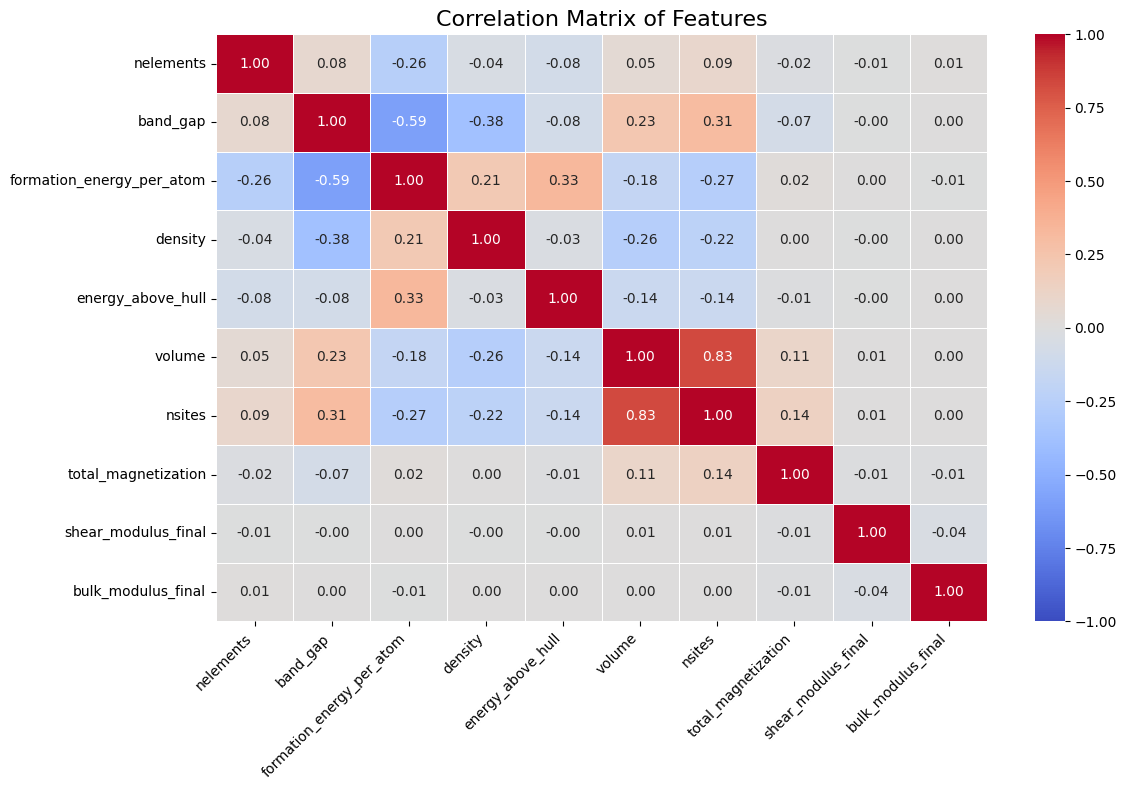

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_matrix(df, features=None):
    """Plot correlation matrix for the given features."""
    # If specific features are provided, filter the DataFrame
    if features:
        df = df[features]

    # Exclude non-numeric columns
    df_numeric = df.select_dtypes(include='number')

    # Calculate the correlation matrix
    corr_matrix = df_numeric.corr()

    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))
    
    # Generate a heatmap of the correlation matrix
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

    # Set title and labels
    plt.title('Correlation Matrix of Features', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Show the plot
    plt.show()

# Usage example
# Plot correlation matrix for all features in the cleaned DataFrame
plot_correlation_matrix(df_cleaned)

In [25]:
from mp_api.client import MPRester

def add_lattice_constants(df):
    a_vals, b_vals, c_vals = [], [], []
    alpha_vals, beta_vals, gamma_vals = [], [], []

    with MPRester(APIKEY) as mpr:
        for mpid in df['material_id']:
            try:
                struct = mpr.get_structure_by_material_id(mpid)
                a, b, c = struct.lattice.abc
                alpha, beta, gamma = struct.lattice.angles
                a_vals.append(a)
                b_vals.append(b)
                c_vals.append(c)
                alpha_vals.append(alpha)
                beta_vals.append(beta)
                gamma_vals.append(gamma)
            except Exception as e:
                print(f"Error retrieving lattice data for {mpid}: {e}")
                a_vals.append(None)
                b_vals.append(None)
                c_vals.append(None)
                alpha_vals.append(None)
                beta_vals.append(None)
                gamma_vals.append(None)

    df['lattice_a'] = a_vals
    df['lattice_b'] = b_vals
    df['lattice_c'] = c_vals
    df['lattice_alpha'] = alpha_vals
    df['lattice_beta'] = beta_vals
    df['lattice_gamma'] = gamma_vals

    return df

df_with_lattice = add_lattice_constants(df_cleaned)


Retrieving MaterialsDoc documents: 100%|██████████| 1/1 [00:00<00:00, 43240.25it/s]


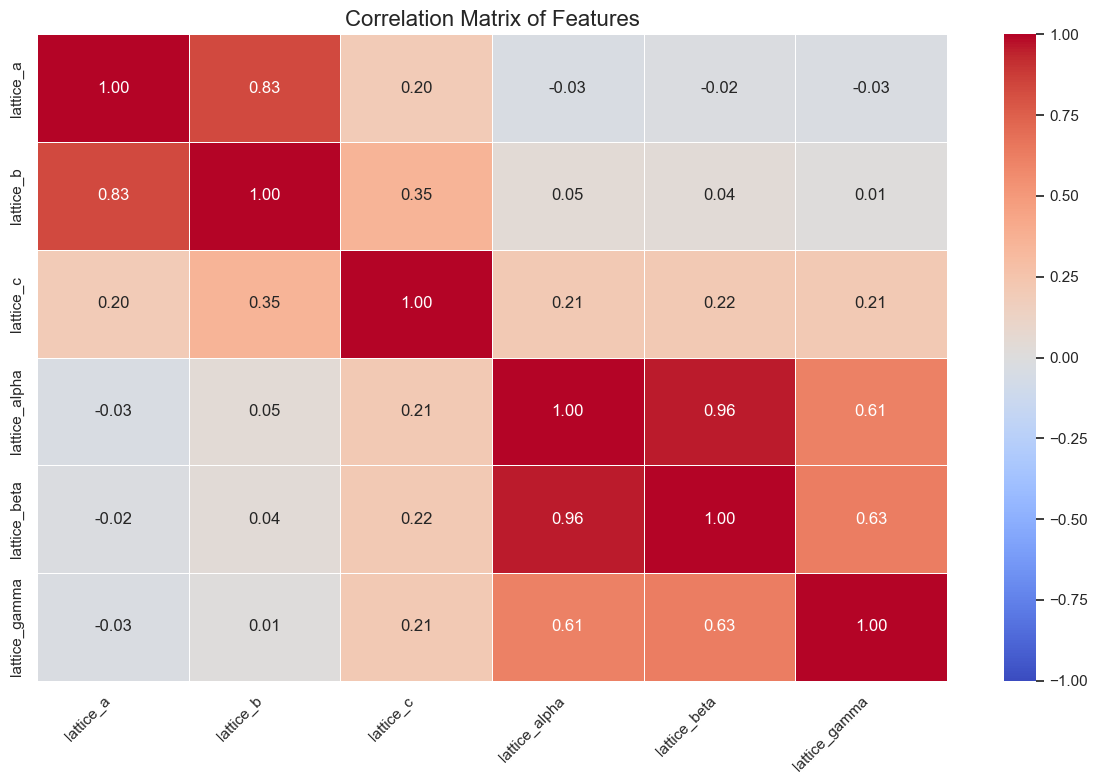

In [139]:
plot_correlation_matrix(df_with_lattice, features=["lattice_a", "lattice_b", "lattice_c", "lattice_alpha", "lattice_beta", "lattice_gamma"])

In [124]:
# Train/Test Split

def train_test_split_custom(df):
    from sklearn.model_selection import train_test_split
    
    final_df = df
    target_columns = ["lattice_a", "lattice_b", "lattice_c", "lattice_alpha", "lattice_beta", "lattice_gamma"]

    X = final_df.drop(columns=target_columns + ['material_id'] + ['formula'] + ['elements'])
    Y = final_df[target_columns]

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.2
    )

    return X_train, X_test, Y_train, Y_test

In [111]:
# Scaling and transforming the features

def scale_and_transform(X_train, X_test, Y_train, Y_test):
  from sklearn.preprocessing import StandardScaler
  import numpy as np
  import pandas as pd

  # Preserve the indices before scaling
  X_train_indices = X_train.index
  X_test_indices = X_test.index

  # Scaling the features (X)
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)  # fit only on training data
  X_test_scaled = scaler.transform(X_test)        # apply same transform to test data

  # Apply log transformation to selected columns with extreme values
  columns_to_log = ['shear_modulus_final', 'bulk_modulus_final', 'volume']
  X_train[columns_to_log] = X_train[columns_to_log].apply(np.log1p)  # log1p handles zeros better
  X_test[columns_to_log] = X_test[columns_to_log].apply(np.log1p)

  # Re-standardize after log transformation
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)

  # Convert numpy arrays back to DataFrames, preserving the indices
  X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train_indices)
  X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test_indices)

  # Handle missing values by dropping rows with NaNs if necessary
  X_train_scaled = X_train_scaled.dropna()
  Y_train_aligned = Y_train.loc[X_train_scaled.index]  # Align Y_train with X_train_scaled
  X_test_scaled = X_test_scaled.dropna()
  Y_test_aligned = Y_test.loc[X_test_scaled.index]    # Align Y_test with X_test_scaled

  return X_train_scaled, X_test_scaled, Y_train_aligned, Y_test_aligned


In [112]:
# functions for evaluating and plotting multi-output regression results

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate_multioutput_regression(y_true, y_pred, target_names=None):
    n_targets = y_true.shape[1]
    print("Performance Metrics per Output:\n")
    
    for i in range(n_targets):
        r2 = r2_score(y_true[:, i], y_pred[:, i])
        mae = mean_absolute_error(y_true[:, i], y_pred[:, i])
        mse = mean_squared_error(y_true[:, i], y_pred[:, i])
        
        name = target_names[i] if target_names else f"Target {i+1}"
        print(f"{name}:")
        print(f"  R²   = {r2:.3f}")
        print(f"  MAE  = {mae:.3f}")
        print(f"  MSE  = {mse:.3f}\n")


def plot_multioutput_regression_results(y_true, y_pred, target_names=None):
    n_targets = y_true.shape[1]
    fig, axs = plt.subplots(2, int(np.ceil(n_targets / 2)), figsize=(15, 8))
    axs = axs.flatten()

    for i in range(n_targets):
        axs[i].scatter(y_true[:, i], y_pred[:, i], alpha=0.6, color='steelblue', edgecolors='k')
        axs[i].plot([y_true[:, i].min(), y_true[:, i].max()],
                    [y_true[:, i].min(), y_true[:, i].max()],
                    'r--', lw=2)
        name = target_names[i] if target_names else f"Target {i+1}"
        axs[i].set_title(f"{name} - Predicted vs Actual")
        axs[i].set_xlabel("Actual")
        axs[i].set_ylabel("Predicted")

    plt.tight_layout()
    plt.show()

Mean Squared Error: 211.23964531400568
Performance Metrics per Output:

lattice_a:
  R²   = 0.480
  MAE  = 0.687
  MSE  = 0.857

lattice_b:
  R²   = 0.651
  MAE  = 0.598
  MSE  = 0.661

lattice_c:
  R²   = 0.491
  MAE  = 0.994
  MSE  = 2.093

lattice_alpha:
  R²   = 0.093
  MAE  = 15.231
  MSE  = 388.771

lattice_beta:
  R²   = 0.090
  MAE  = 15.051
  MSE  = 377.788

lattice_gamma:
  R²   = 0.121
  MAE  = 18.123
  MSE  = 497.269



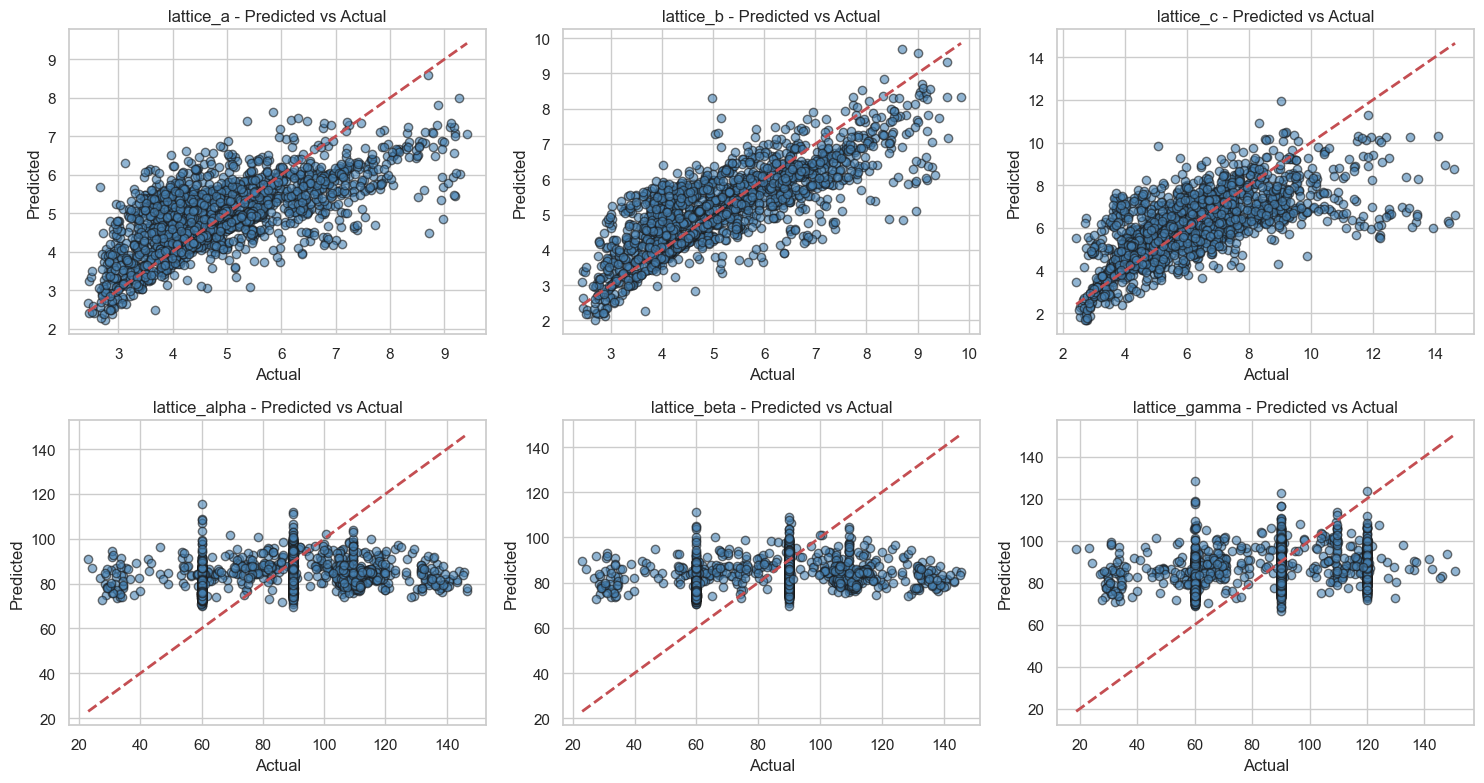

In [138]:
# Linear Regression Model

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train_linreg, X_testlinreg, Y_trainlinreg, Y_testlinreg = train_test_split_custom(df_with_lattice)
X_train_scaled_linreg, X_test_scaled_linreg, Y_train_aligned_linreg, Y_test_aligned_linreg = scale_and_transform(X_train_linreg, X_testlinreg, Y_trainlinreg, Y_testlinreg)

model = LinearRegression()
model.fit(X_train_scaled_linreg, Y_train_aligned_linreg)

# Predict
y_pred_linreg = model.predict(X_test_scaled_linreg)
lattice_features = [
    "lattice_a", "lattice_b", "lattice_c",
    "lattice_alpha", "lattice_beta", "lattice_gamma"
]
mse = mean_squared_error(Y_test_aligned_linreg, y_pred_linreg)
print("Mean Squared Error:", mse)

# Evaluate
evaluate_multioutput_regression(Y_test_aligned_linreg.to_numpy(), y_pred_linreg, target_names=lattice_features)

# Plot
plot_multioutput_regression_results(Y_test_aligned_linreg.to_numpy(), y_pred_linreg, target_names=lattice_features)

ElasticNet Model Performance:
R² = 0.329
MSE = 205.385
Performance Metrics per Output:

lattice_a:
  R²   = 0.464
  MAE  = 0.682
  MSE  = 0.852

lattice_b:
  R²   = 0.642
  MAE  = 0.579
  MSE  = 0.645

lattice_c:
  R²   = 0.512
  MAE  = 1.004
  MSE  = 2.143

lattice_alpha:
  R²   = 0.107
  MAE  = 15.244
  MSE  = 378.487

lattice_beta:
  R²   = 0.107
  MAE  = 14.995
  MSE  = 363.841

lattice_gamma:
  R²   = 0.142
  MAE  = 17.995
  MSE  = 486.341



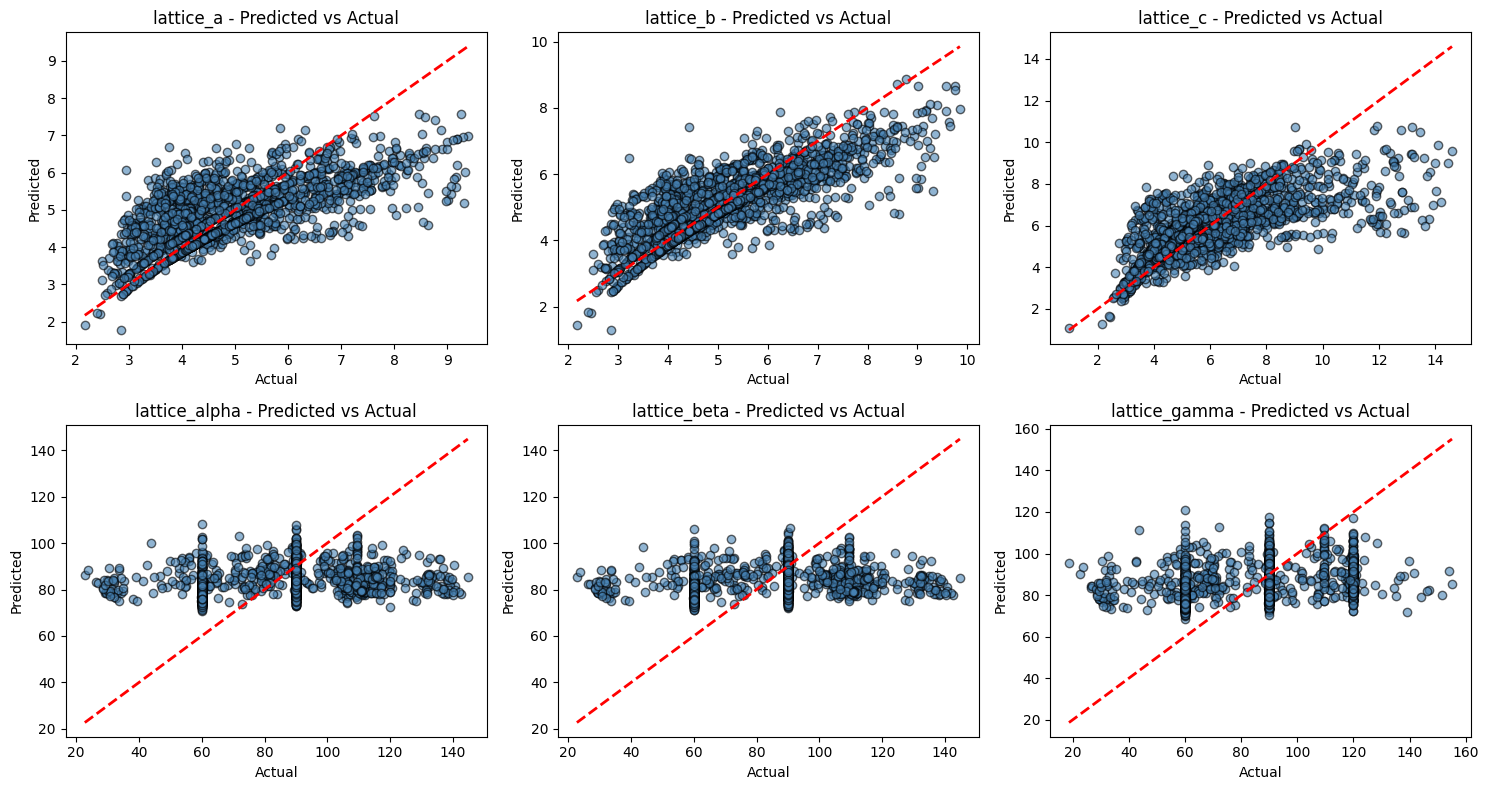

In [ ]:
# ElasticNet Regression

from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X_train_EN, X_test_EN, Y_train_EN, Y_test_EN = train_test_split_custom(df_with_lattice)
X_train_scaled_EN, X_test_scaled_EN, Y_train_aligned_EN, Y_test_aligned_EN = scale_and_transform(X_train_EN, X_test_EN, Y_train_EN, Y_test_EN)

# Initialize the ElasticNet model with alpha and l1_ratio (ElasticNet mix ratio)
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.9)  # alpha controls regularization strength

# Train the model on the training data
elastic_net.fit(X_train_scaled_EN, Y_train_aligned_EN)

# Predict the target values on the test set
Y_pred_EN = elastic_net.predict(X_test_scaled_EN)


# Evaluate the model's performance
r2 = r2_score(Y_test_aligned_EN, Y_pred_EN)
mse = mean_squared_error(Y_test_aligned_EN, Y_pred_EN)

print(f"ElasticNet Model Performance:")
print(f"R² = {r2:.3f}")
print(f"MSE = {mse:.3f}")

# Evaluate
evaluate_multioutput_regression(Y_test_aligned_EN.to_numpy(), Y_pred_EN, target_names=lattice_features)

# Plot
plot_multioutput_regression_results(Y_test_aligned_EN.to_numpy(), Y_pred_EN, target_names=lattice_features)



Training model for: lattice_a
  R²   = 0.622
  MSE  = 0.639

Training model for: lattice_b
  R²   = 0.758
  MSE  = 0.439

Training model for: lattice_c
  R²   = 0.661
  MSE  = 1.482

Training model for: lattice_alpha
  R²   = 0.484
  MSE  = 213.139

Training model for: lattice_beta
  R²   = 0.490
  MSE  = 204.252

Training model for: lattice_gamma
  R²   = 0.431
  MSE  = 308.355


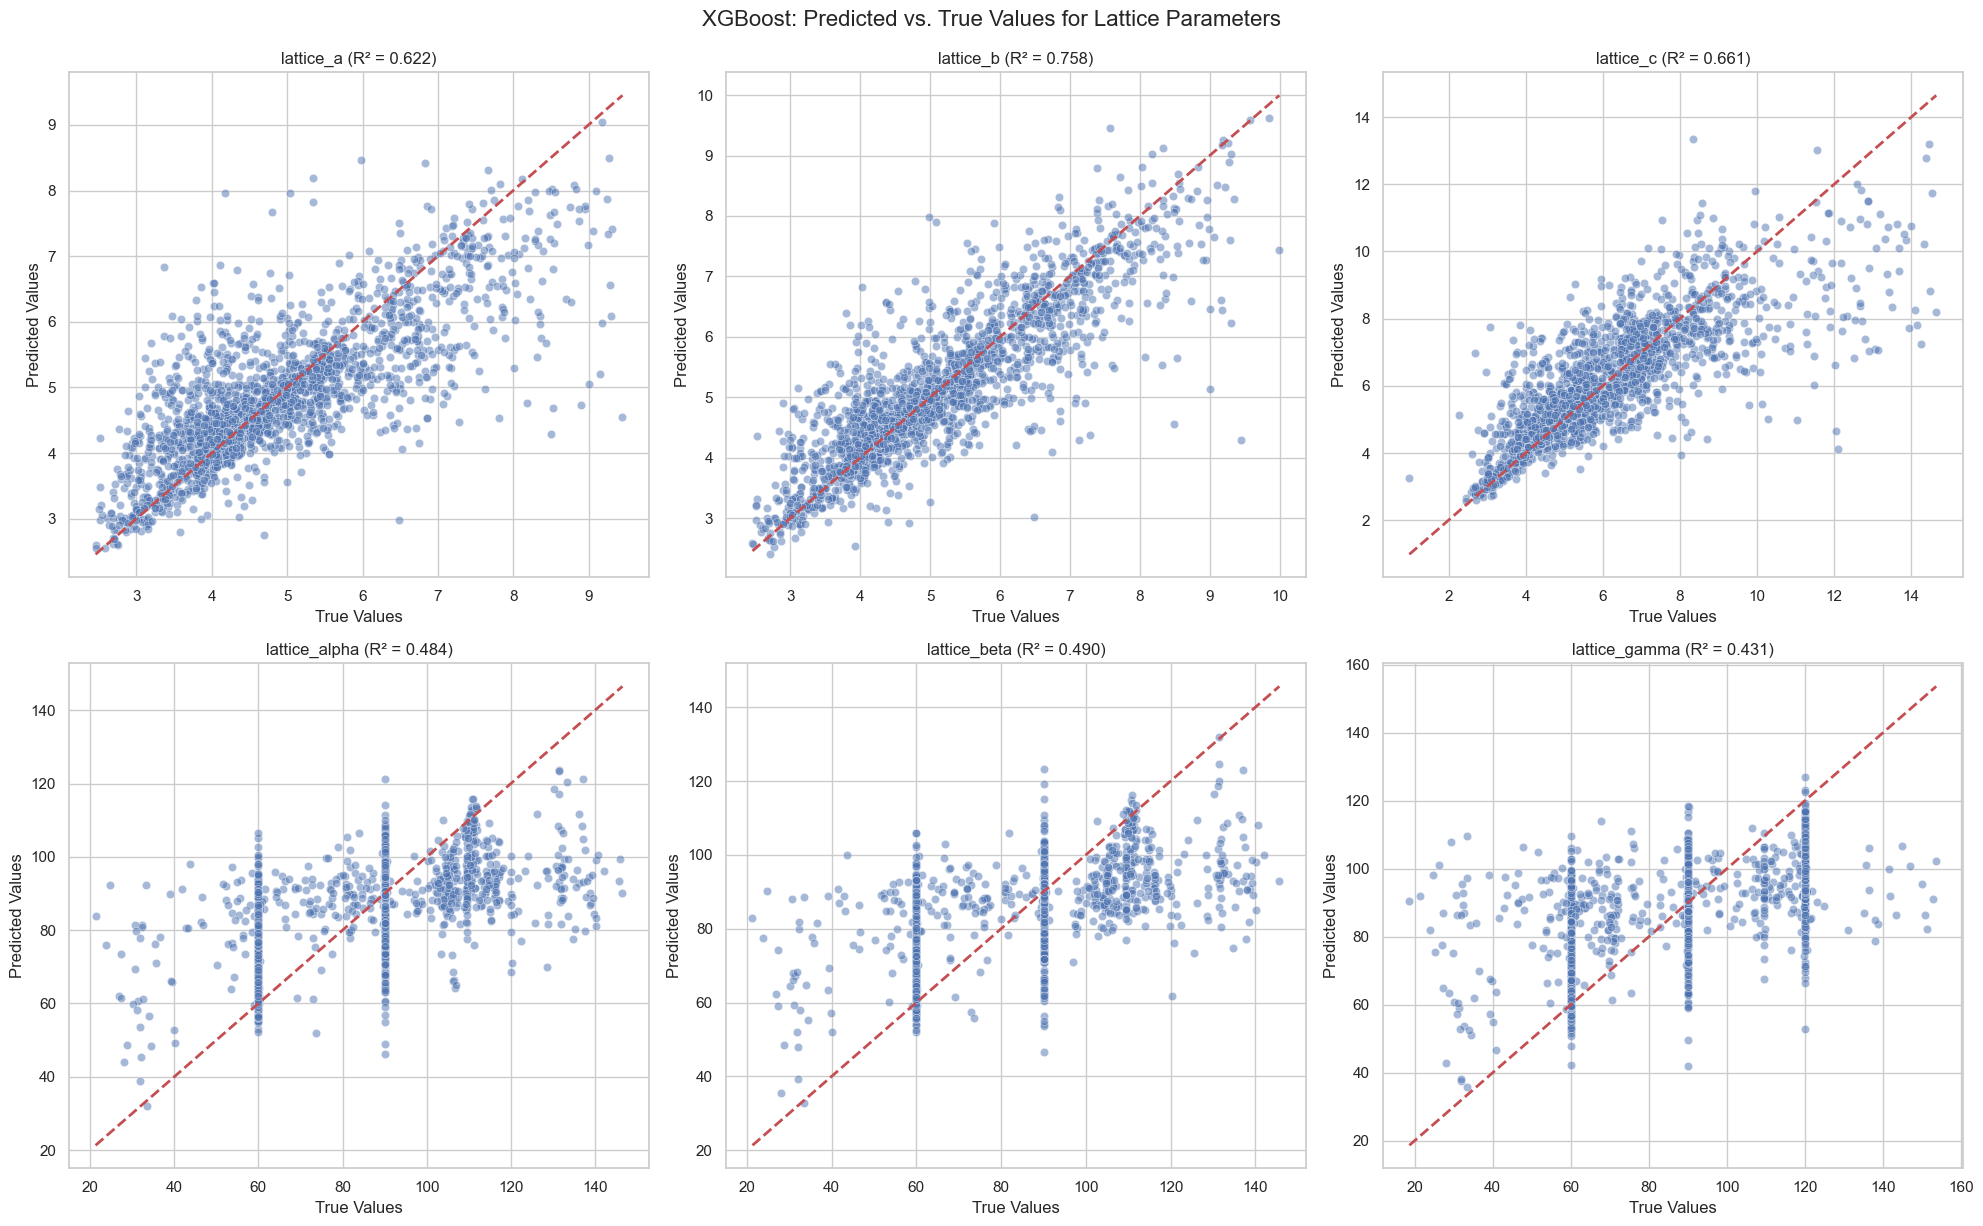

In [137]:
# XGBoost Regression

import xgboost as xgb

X_train_XG, X_test_XG, Y_train_XG, Y_test_XG = train_test_split_custom(df_with_lattice)
X_train_scaled_XG, X_test_scaled_XG, Y_train_aligned_XG, Y_test_aligned_XG = scale_and_transform(X_train_XG, X_test_XG, Y_train_XG, Y_test_XG)

# Dictionary to hold models and metrics
xgb_models = {}
performance_metrics = {}

target_columns = ['lattice_a', 'lattice_b', 'lattice_c', 'lattice_alpha', 'lattice_beta', 'lattice_gamma']

# Train a separate model for each target
for target in target_columns:
  print(f"\nTraining model for: {target}")
  
  y_train_target_XG = Y_train_aligned_XG[target]
  y_test_target_XG = Y_test_aligned_XG[target]
  
  model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=6, n_jobs=-1)
  model.fit(X_train_scaled_XG, y_train_target_XG)
  
  # Predict
  y_pred_XG = model.predict(X_test_scaled_XG)
  
  # Evaluate
  r2 = r2_score(y_test_target_XG, y_pred_XG)
  mse = mean_squared_error(y_test_target_XG, y_pred_XG)
  
  performance_metrics[target] = {'R2': r2, 'MSE': mse}
  xgb_models[target] = model

  print(f"  R²   = {r2:.3f}")
  print(f"  MSE  = {mse:.3f}")

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(20, 12))

# Plot one subplot for each lattice parameter
for i, target in enumerate(target_columns):
    y_test = Y_test_aligned_XG[target]
    y_pred = xgb_models[target].predict(X_test_scaled_XG)
    
    plt.subplot(2, 3, i+1)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(f"{target} (R² = {performance_metrics[target]['R2']:.3f})")

plt.tight_layout()
plt.suptitle("XGBoost: Predicted vs. True Values for Lattice Parameters", fontsize=16, y=1.02)
plt.show()
